## 25. Obtenga con spark los datos (de forma ya agregada) que le permitan realizar la siguiente visualización y realice la misma (⭐⭐⭐)

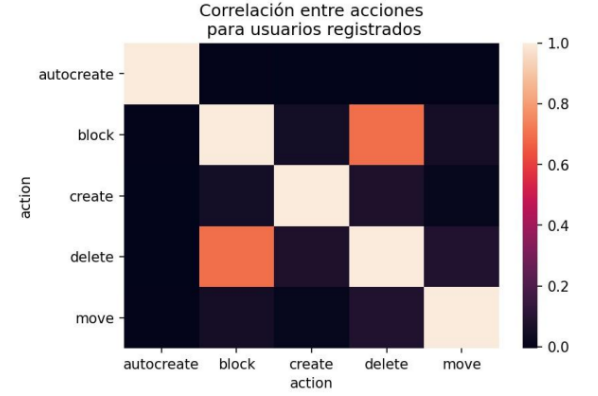

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from pyspark.sql import *
from pyspark.sql.functions import *
from pyspark import SparkContext
from pyspark.sql import SQLContext

In [2]:
spark = SparkSession.builder.getOrCreate()

In [3]:
rdd = spark.read.parquet("../Dataset/logs.parquet", header = True).rdd
rdd.takeSample(False, 5)

[Row(item_id=6983283, timestamp='2013-10-18T16:05:24Z', contributor_username='SALVADOR GIL BARRIOS MARTINEZ', contributor_id=2835338.0, contributor_ip=None, comment=None, logtype='newusers', action='create', title='Usuario:SALVADOR GIL BARRIOS MARTINEZ'),
 Row(item_id=9096617, timestamp='2015-05-04T06:23:42Z', contributor_username='Carpaulex', contributor_id=3722695.0, contributor_ip=None, comment='iOS App Account Creation', logtype='newusers', action='create', title='Usuario:Carpaulex'),
 Row(item_id=4144920, timestamp='2010-09-27T22:15:56Z', contributor_username='Rastrojo', contributor_id=122377.0, contributor_ip=None, comment='Robot: La categoría ha sido movida a [[:Category:Miembros del Foro de São Paulo|Miembros del Foro de São Paulo]]', logtype='delete', action='delete', title='Categoría:Miembros del Foro de Sao Paulo'),
 Row(item_id=8810639, timestamp='2015-04-19T15:27:10Z', contributor_username='Maintenance script', contributor_id=3643376.0, contributor_ip=None, comment='[[m:Sp

In [4]:
actions = ["autocreate", "block", "create", "delete", "move"]

In [5]:
def map_actions(x):
    lista = []
    for i in range(len(actions)):
        lista += [1] if x == actions[i] else [0]
    return lista

rddActions = rdd.filter(lambda x: (x["action"] in actions) and (x["contributor_username"] is not None))\
                .map(lambda x: (x["contributor_username"], map_actions(x["action"])))\
                .reduceByKey(lambda a, b: [x + y for x, y in zip(a, b)])\
                .cache()
rddActions.take(5)

[('Txo', [0, 1654, 190, 2463, 765]),
 ('P. Zinhard', [0, 0, 0, 0, 1]),
 ('RuidoBlanco', [0, 0, 0, 0, 12]),
 ('Soniabelinchon', [0, 0, 0, 0, 1]),
 ('Revoltoso123', [0, 0, 1, 0, 0])]

In [6]:
users = rddActions.count()
users

6114059

In [7]:
means = rddActions.reduce(lambda a, b: (0, [x + y for x, y in zip(a[1], b[1])]))[1]
means = [x[0] / users for x in zip(means)]
means

[0.2238813855083832,
 0.055977870020554266,
 0.9716314481100036,
 0.3919311213712527,
 0.14078470619926958]

In [8]:
# Creo una matriz con las 3 sumatorias que necesito ((x_i - x_mean)*(y_i-y_mean); (x_i - x_mean)^2; (y_i - y_mean)^2)
sumatorias = []
for i in range(len(actions)):
    sumatorias += [[]]
    for j in range(len(actions)):
        sumatorias[i] += [
            rddActions.map(lambda x: [
                                (x[1][i] - means[i]) * (x[1][j] - means[j]),
                                (x[1][i] - means[i]) ** 2,
                                (x[1][j] - means[j]) ** 2
                        ])\
                      .reduce(lambda a, b: [a[0]+b[0], a[1]+b[1], a[2]+b[2]])
        ]
sumatorias

[[[1062387.7863537574, 1062387.7863537574, 1062387.7863537574],
  [-65610.85195355133, 1062387.7863537574, 2943653691.483738],
  [-1048236.4453340734, 1062387.7863537574, 39521986008.692406],
  [-471974.72527945583, 1062387.7863537574, 107175643880.20993],
  [56288.515316832156, 1062387.7863537574, 38882033365.68846]],
 [[-65610.85195355133, 2943653691.483738, 1062387.7863537574],
  [2943653691.483738, 2943653691.483738, 2943653691.483738],
  [527389039.20119214, 2943653691.483738, 39521986008.692406],
  [12342252093.718441, 2943653691.483738, 107175643880.20993],
  [562992320.1556218, 2943653691.483738, 38882033365.68846]],
 [[-1048236.4453340734, 39521986008.692406, 1062387.7863537574],
  [527389039.20119214, 39521986008.692406, 2943653691.483738],
  [39521986008.692406, 39521986008.692406, 39521986008.692406],
  [4566436697.327566, 39521986008.692406, 107175643880.20993],
  [536922836.6846112, 39521986008.692406, 38882033365.68846]],
 [[-471974.72527945583, 107175643880.20993, 10623

In [9]:
corr_matrix = []
for i in range(len(sumatorias)):
    corr_matrix += [[]]
    for element in sumatorias[i]:
        corr_matrix[i] += [element[0] / (np.sqrt(element[1]) * np.sqrt(element[2]))]
corr_matrix

[[1.0000000000000002,
  -0.001173250598966988,
  -0.005115620754071327,
  -0.0013987147576454292,
  0.0002769515338830711],
 [-0.001173250598966988,
  1.0,
  0.04889544034094629,
  0.6948691074720394,
  0.052624093582225355],
 [-0.005115620754071327,
  0.04889544034094629,
  1.0,
  0.07016330061618979,
  0.013696765225945423],
 [-0.0013987147576454292,
  0.6948691074720394,
  0.07016330061618979,
  1.0000000000000002,
  0.083803651513442],
 [0.0002769515338830711,
  0.052624093582225355,
  0.013696765225945423,
  0.083803651513442,
  1.0]]

[Text(0, 0.5, 'autocreate'),
 Text(0, 1.5, 'block'),
 Text(0, 2.5, 'create'),
 Text(0, 3.5, 'delete'),
 Text(0, 4.5, 'move')]

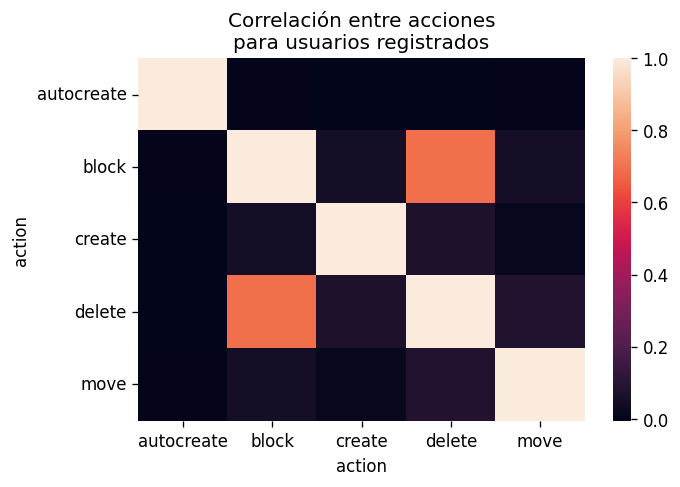

In [10]:
plt.subplots(dpi = 120)
ax = sns.heatmap(corr_matrix, xticklabels = actions)
ax.set_title("Correlación entre acciones\npara usuarios registrados")
ax.set_xlabel("action")
ax.set_ylabel("action")
ax.set_yticklabels(actions, rotation = 0)